In [1]:
import numpy as np
from astropy.table import Table,Column
from astropy.io import fits
import matplotlib.pyplot as plt
import bz2
import pdb
import warnings
import os
from astropy import wcs
plt.rcParams['text.usetex']=True
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25 
import Image,ImageOps
import urllib, cStringIO
from astropy.modeling import models, fitting


%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

from astropy.coordinates import SkyCoord
from photutils import CircularAperture
import astropy.units as u
from photutils import aperture_photometry
from photutils import Background2D, SigmaClip, MedianBackground

In [2]:
#table of ukidss galaxies
data = Table.read('../data/ukidss_gz2_rh_debiased.fits')
vol_lim = data[(data['REDSHIFT']<0.06) & (data['PETROMAG_MR']<-20)]

In [70]:
def get_file_downloadname(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']
    strname = strname = 'http://das.sdss.org/raw/'+'{:03d}'.format(r)+'/'+'{:1d}'.format(rr)+'/corr/'+'{:1d}'.format(c)+'/fpC-'+'{:06d}'.format(r)+'-r'+'{:1d}'.format(c)+'-'+'{:04d}'.format(f)+'.fit.gz'+'\n'
    return strname

def get_tsf_downloadname(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']    
    strname = 'http://das.sdss.org/imaging/{:1d}/{:1d}/calibChunks/{:1d}/tsField-{:06d}-{:1d}-{:1d}-{:04d}.fit'.format(r,rr,c,r,c,rr,f)
    return strname

def get_filename(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']
    strname = strname = 'dr7_frames/fpC-'+'{:06d}'.format(r)+'-r'+'{:1d}'.format(c)+'-'+'{:04d}'.format(f)+'.fit.gz'
    return strname

def get_tsfname(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']
    strname = strname = 'dr7_frames/tsField-'+'{:06d}-'.format(r)+'{:1d}'.format(c)+'-'+'{:1d}-'.format(rr)+'{:04d}'.format(f)+'.fit'
    return strname

def get_ukidss_file(gal):
    strname = 'ukidss_frames/{:1d}_J_1.fits.gz'.format(gal['dr7objid'])
    return strname

#function for getting galaxy images
def optical_image(gal):
    
    pixelsize=0.396
    height=424
    width=424

    #scale=.02*gal['PETROR90_R']/pixelsize/width
    scale = .02*gal['PETROR90_R']
    # form wurl to query SDSS web sevice to generate cutout image
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(gal['RA'])
    cutOutImageUrl += "&dec=" + str(gal['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)
    
    file = cStringIO.StringIO(urllib.urlopen(cutOutImageUrl).read())
    img = Image.open(file)    
    return img

def IR_image(gal):
    
    
    file = cStringIO.StringIO(urllib.urlopen(gal['UKIDSS_url']).read())
    img = Image.open(file)    
    return img

In [393]:
def tsf_params(tsf):
    r_zero=tsf[1].data.aa[0][2]
    r_kk=tsf[1].data.kk[0][2]
    r_airmass = tsf[1].data.airmass[0][2]
    
    return r_zero,r_kk,r_airmass

def sdss_cutout(gal):
    frame = fits.open(get_filename(gal))
    
    ra = gal['RA']
    dec = gal['DEC']
    rad = gal['petrorad_r']
    
    img = frame[0].data
    hdr = frame[0].header

    #get coordinates of subject
    w = wcs.WCS(hdr)
    pix = w.wcs_world2pix(ra, dec,1)
    row, col = int(pix[1]), int(pix[0])

    size = 6. #total size of cutout = 6*petro_r
    extents = [int(row-size*rad), int(row+size*rad), int(col-size*rad), int(col+size*rad)] 
    
    if (extents[1] > hdr['NAXIS2']) or (extents[3] > hdr['NAXIS1']) or all(i > 0 for i in extents)==False: #galaxy on edge - add to bad list
        size = 3. #try smaller size
        extents = [int(row-size*rad), int(row+size*rad), int(col-size*rad), int(col+size*rad)] 
        if (extents[1] > hdr['NAXIS2']) or (extents[3] > hdr['NAXIS1']) or all(i > 0 for i in extents)==False:
            #galaxy still too close to edge to measure background
            return 'edgegal'
        else:
            cutout = img[extents[0]:extents[1], extents[2]:extents[3]]
            return cutout

    else:        
        cutout = img[extents[0]:extents[1], extents[2]:extents[3]]
        return cutout

def subtract_sky(cutout,box_int,edge_method='crop'):
    box_size=int(cutout.shape[0]/box_int)
    bkg_estimator = MedianBackground()
    bkg = Background2D(cutout,box_size=box_size,edge_method=edge_method)
    cutout = cutout - bkg.background
    return cutout


def counts_to_f_f0(cutout,r_zero,r_kk,r_airmass,exp_time=53.907):
    #convert counts to flux, sdss
    f_f0 = (cutout/exp_time)*(10**(.4*(r_zero+r_kk*r_airmass)))
    return f_f0

def crop_ukidss_cutout(u_cutout,r_cutout):
    #crop ukidss cutout to cover same width in arcsec as the sdss cutout
    sdss_width = r_cutout.shape[0] #r width in pixels
    ukidss_desired_width_pixel = int(sdss_width*.396/.4) #desired width in pixels for ukidss cutout
    trim_length = int((u_cutout.shape[0]-ukidss_desired_width_pixel)/2.) 
    extents = [trim_length, trim_length+ukidss_desired_width_pixel,trim_length,trim_length+ukidss_desired_width_pixel]

    return u_cutout[extents[0]:extents[1], extents[2]:extents[3]]
    
def get_sb_profile(gal):
    
    cutout = sdss_cutout(gal)
    
    #zeropoints, extinction, and airmass
    tsf = fits.open(get_tsfname(gal))
    r_zero,r_kk,r_airmass = tsf_params(tsf)
    
    center_pix = cutout.shape[0]/2+1 #center of galaxy / cutout
    positions = [(center_pix,center_pix)] #center of aperture
    radii = np.linspace(1,center_pix-1,100) #100 apertures
    
    #subtract padding from cutout
    cutout = cutout - 1000 #softbias
    flux_cutout = counts_to_f_f0(cutout,r_zero,r_kk,r_airmass) #convert counts to f/f0
    flux_cutout = subtract_sky(flux_cutout,3) #subtract sky

        
    avg_flux = []
    for r in radii: #calculate counts for each aperture with radius r
        apertures = CircularAperture(positions,r=r)
        phot_table = aperture_photometry(flux_cutout,apertures,method='subpixel')
        flux_in_aperture = phot_table['aperture_sum'][0]
        area = np.pi*(r**2) #area in pixels
        #area = np.pi*(r**2)*.396 #area in arcsec
        avg_flux.append(flux_in_aperture/area) #get flux per arcsec 
    
        
    return flux_cutout,radii*.396,avg_flux

def get_sb_ukidss(gal):
    fits_file = fits.open(get_ukidss_file(gal))
    
    extcorr=-1*fits_file[1].header['EXTINCT']*(((fits_file[0].header['AMSTART']+fits_file[0].header['AMEND'])/2)-1)
    texpcorr = 2.5*np.log10(fits_file[0].header['EXP_TIME'])
    magzpt = fits_file[1].header['MAGZPT']
    
    cutout=fits_file[1].data #already in flux unites
    
    center_pix = cutout.shape[0]/2+1 #center of galaxy / cutout
    positions = [(center_pix,center_pix)] #center of aperture
    radii = np.linspace(1,center_pix-1,100) #100 apertures
    
    #subtract sky 
    cutout = subtract_sky(cutout,3)

    avg_flux = []
    for r in radii: #calculate flux for each aperture with radius r
        apertures = CircularAperture(positions,r=r)
        phot_table = aperture_photometry(cutout,apertures,method='subpixel')
        flux_in_aperture = phot_table['aperture_sum']
        area = np.pi*(r**2) #area in pixels (number of pixels in aperture)
        #area = np.pi*(r**2)*.4 #area in arcsec
        avg_flux.append(flux_in_aperture/area) #get flux per arcsec 
        
    return cutout,radii*.4,avg_flux

def measure_noise(cutout_flux,band):
    if band =='r': #r band, scale cutout
        flux=cutout_flux
    else:
        flux=cutout_flux
    min_flux = np.min(flux)
    mean_estimate = np.average(flux)
    sig_estimate = (mean_estimate-min_flux)/2
    max_flux = mean_estimate+sig_estimate*2

    hist,bin_edges,c=plt.hist(np.ravel(flux),bins=100,range=(min_flux,max_flux))
    bin_halfwidth = (bin_edges[1]-bin_edges[0])/2.
    bin_centers = [b+bin_halfwidth for b in bin_edges][:-1]
    amp_estimate= np.max(hist)
    #fit to gaussian
    g_init = models.Gaussian1D(amplitude=amp_estimate, mean=mean_estimate, stddev=sig_estimate)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, bin_centers, hist)
    return abs(g.stddev.value)
    
def SN_vs_radius(gal,band):
    if band=='r':
        cutout_flux,radii,flux_per_area = get_sb_profile(gal)
    else:
        cutout_flux,radii,flux_per_area = get_sb_ukidss(gal)
        
    noise = measure_noise(cutout_flux,band)
    
    #calculate where S/N drops below 5
    sn=flux_per_area/noise
    try:
        r_lim=radii[len(sn[sn>5])]
    except IndexError:
        r_lim=radii[len(sn[sn>5])-1]
    
    return cutout_flux,radii,flux_per_area,noise,r_lim

In [5]:
cr=Column(np.zeros(len(vol_lim)),name='RSN5_r')
cu = Column(np.zeros(len(vol_lim)),name='RSN5_j')

In [6]:
vol_lim.add_columns([cr,cu])

### Workflow; calculating S/N 

In [329]:
gal=vol_lim[7]

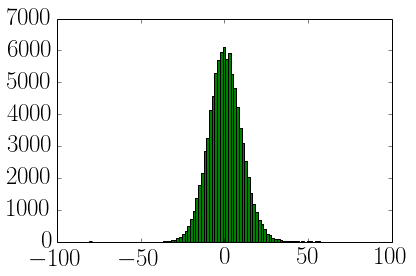

In [330]:
cutout_flux,radii,flux_per_area,noise,r_lim=SN_vs_radius(gal,'r')
u_cutout_flux,u_radii,u_flux_per_area,u_noise,u_lim=SN_vs_radius(gal,'J')

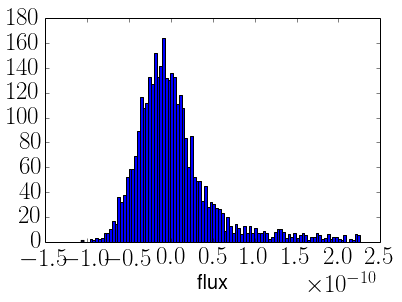

In [331]:
flux=cutout_flux #cutout in flux units
min_flux = np.min(flux)
mean_estimate = np.average(flux)
sig_estimate = (mean_estimate-min_flux)/2
max_flux = mean_estimate+sig_estimate*2

hist,bin_edges,c=plt.hist(np.ravel(flux),bins=100,range=(min_flux,max_flux))
bin_halfwidth = (bin_edges[1]-bin_edges[0])/2.
bin_centers = [b+bin_halfwidth for b in bin_edges][:-1]
amp_estimate = np.max(hist)
plt.xlabel('flux',fontsize=20)

(-1.0730039721613322e-10, 2.2604380814558524e-10)

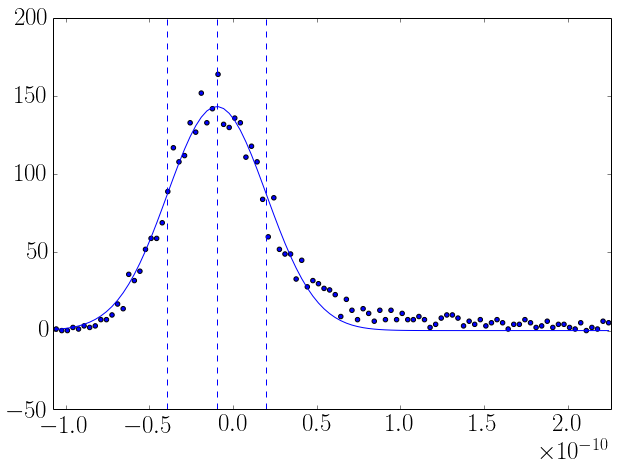

In [332]:
f=plt.figure(figsize=(10,7))
g_init = models.Gaussian1D(amplitude=amp_estimate, mean=mean_estimate, stddev=sig_estimate)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, bin_centers, hist)

plt.scatter(bin_centers,hist)
plt.plot(bin_centers, g(bin_centers), label='{:.2f}'.format(g.stddev.value))
plt.axvline(g.mean.value,ls='dashed')
plt.axvline(g.mean.value+g.stddev.value,ls='dashed')
plt.axvline(g.mean.value-g.stddev.value,ls='dashed')
plt.xlim(min_flux,max_flux)


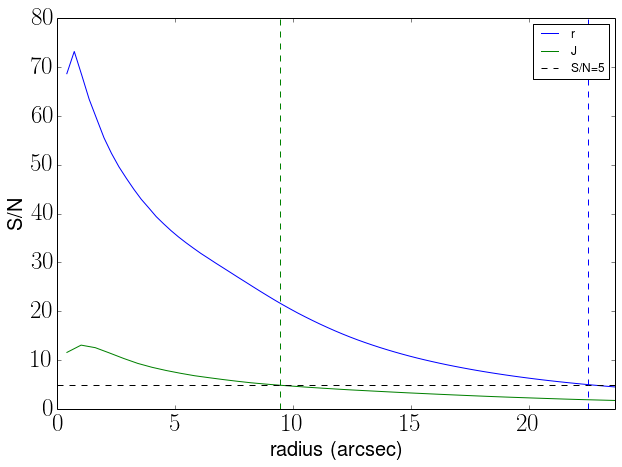

In [400]:
f=plt.figure(figsize=(10,7))
sn = flux_per_area/noise
sn_u=u_flux_per_area/u_noise
plt.plot(radii,sn,c='b',label='r')
plt.plot(u_radii,sn_u,c='g',label='J')
plt.axhline(5,c='k',label='S/N=5',ls='dashed')
plt.axvline(r_lim,c='b',ls='dashed')
plt.axvline(u_lim,c='g',ls='dashed')
plt.xlim(0,gal['PETROR90_R']+10)
plt.xlabel('radius (arcsec)',fontsize=20)
plt.ylabel('S/N',fontsize=20)
plt.legend()

In [397]:
gal=vol_lim[4]
cutout_flux,radii,flux_per_area,noise,r_lim=SN_vs_radius(gal,'r')
u_cutout_flux,u_radii,u_flux_per_area,u_noise,u_lim=SN_vs_radius(gal,'J')
plt.close()

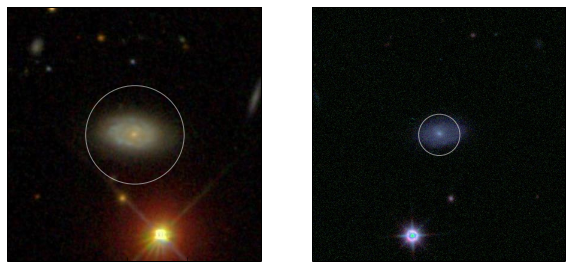

In [398]:
f=plt.figure(figsize=(10,5))
gs=gridspec.GridSpec(1,2)
ax=plt.subplot(gs[0,0])#left-most is gz2 image
plt.imshow(optical_image(gal))
plt.tick_params(labelbottom='off',labelleft='off')
circle=plt.Circle((213,213),r_lim/(.02*gal['PETROR90_R']),fill=False,color='w',alpha=.5)
ax.add_artist(circle)
    
ax = plt.subplot(gs[0,1]) #right is ukidss image
plt.imshow(IR_image(gal))
circle=plt.Circle((213,213),u_lim/(.02*gal['PETROR90_R']),fill=False,color='w',alpha=.5)
ax.add_artist(circle)
plt.tick_params(labelbottom='off',labelleft='off')


In [399]:
gal['dr7objid'],r_lim,u_lim

(587722981747392587, 22.516000000000002, 9.4303030303030297)

# Getting UKIDSS fits cutouts: they only accept 500 subjects at a time, so create 20 csv files of objid, RA, DEC: http://wsa.roe.ac.uk:8080/wsa/MultiGetImage_form.jsp

In [22]:
def write_table(i,lo,hi):
    t=Table()
    ra=Column(vol_lim[lo:hi]['RA'])
    dec=Column(vol_lim[lo:hi]['DEC'])
    objid = Column(vol_lim[lo:hi]['dr7objid'])
    t.add_columns([ra,dec,objid])
    fname = 'data_coordinates/file_{}_{}_thru_{}.csv'.format(i,lo,hi-1)
    t.write(fname,overwrite=True)
    #print fname
for i in range(0,len(vol_lim)/500+1):
    if i==20: #last file, <500 subjects
        lo = i*500
        hi = len(vol_lim)
    else:
        lo = i*500
        hi = (i+1)*500
    write_table(i,lo,hi)

# Workflow: calculating S/N within some radius 

In [361]:
gal=vol_lim[0]
cutout_flux,radii,flux_per_area,noise,r_lim=SN_vs_radius(gal,'r')
plt.close()

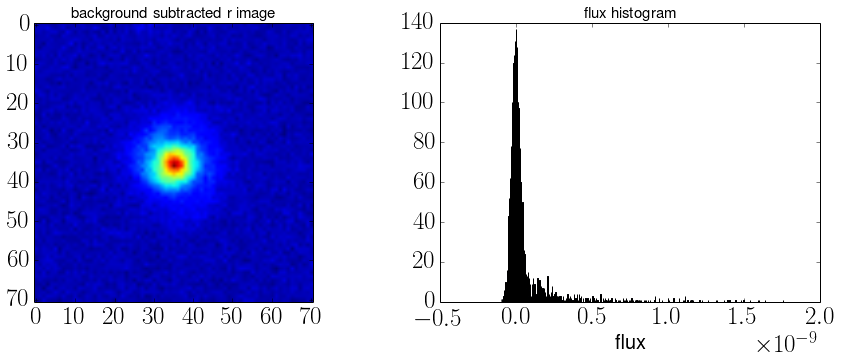

In [272]:
f=plt.figure(figsize=(15,5))
ax=plt.subplot(gs[0,0])
plt.imshow(cutout_flux)
plt.title('background subtracted r image',fontsize=15)
ax=plt.subplot(gs[0,1])
hist,bin_edges,c=plt.hist(np.ravel(cutout_flux),bins=1000)
plt.title('flux histogram',fontsize=15)
plt.xlabel('flux',fontsize=20)

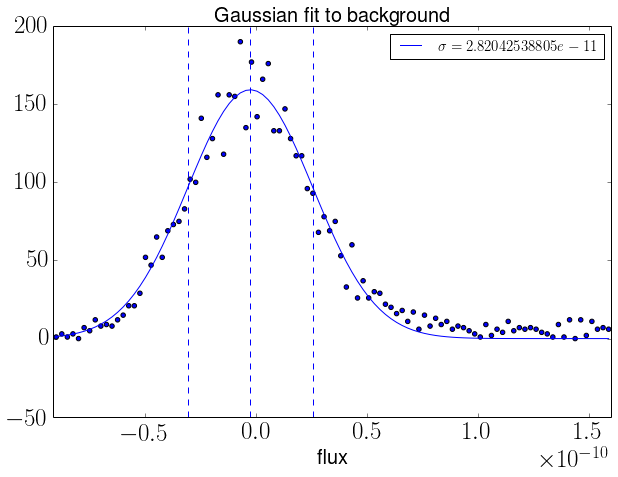

In [284]:
flux=cutout_flux #cutout in flux units
min_flux = np.min(flux)
mean_estimate = np.average(flux)
sig_estimate = (mean_estimate-min_flux)/2
max_flux = mean_estimate+sig_estimate*2

hist,bin_edges,c=plt.hist(np.ravel(flux),bins=100,range=(min_flux,max_flux))
bin_halfwidth = (bin_edges[1]-bin_edges[0])/2.
bin_centers = [b+bin_halfwidth for b in bin_edges][:-1]
amp_estimate = np.max(hist)
plt.close()
f=plt.figure(figsize=(10,7))
g_init = models.Gaussian1D(amplitude=amp_estimate, mean=mean_estimate, stddev=sig_estimate)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, bin_centers, hist)

plt.scatter(bin_centers,hist)
plt.plot(bin_centers, g(bin_centers), label='$\sigma ={}$'.format(g.stddev.value))
plt.axvline(g.mean.value,ls='dashed')
plt.axvline(g.mean.value+g.stddev.value,ls='dashed')
plt.axvline(g.mean.value-g.stddev.value,ls='dashed')
plt.xlim(min_flux,max_flux)
plt.legend(fontsize=15)
plt.xlabel('flux',fontsize=20)
plt.title('Gaussian fit to background',fontsize=20)

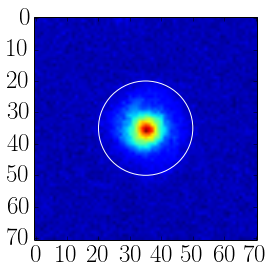

In [358]:
#now with circles:
r=15
ax=plt.subplot()
plt.imshow(flux_cutout)
circle=plt.Circle((flux_cutout.shape[0]/2,flux_cutout.shape[0]/2),r,fill=False,color='w')
ax.add_artist(circle)


In [360]:
positions = [(flux_cutout.shape[0]/2,flux_cutout.shape[0]/2)] #center of aperture
apertures = CircularAperture(positions,r=r)
phot_table = aperture_photometry(flux_cutout,apertures,method='subpixel')
number_of_pixels = np.pi*r**2
area_arcsec = number_of_pixels*.396
print 'noise, equaling sigma of the gaussian fit to background: {}'.format(noise)
print 'sum of flux in aperture: {}'.format(phot_table['aperture_sum'][0])
print 'average flux per pixel in aperture: {}'.format(phot_table['aperture_sum'][0]/number_of_pixels)
print 'S/N within aperture: {}'.format(phot_table['aperture_sum'][0]/number_of_pixels/noise)
#print 'average flux per arcsec: {}'.format(phot_table['aperture_sum'][0]/area_arcsec)

noise, equaling sigma of the gaussian fit to background: 3.14220636239e-11
sum of flux in aperture: 1.86540702486e-07
average flux per pixel in aperture: 2.63901110119e-10
S/N within aperture: 8.39859257106


In [44]:
newdata2=Table.read('../sb_profiles/newdata2.fits')

In [27]:
newdata=Table.read('../sb_profiles/r_SN.fits')

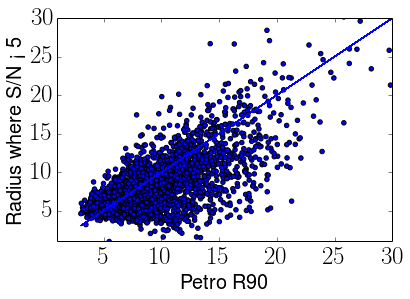

In [39]:
plt.scatter(newdata['PETROR90_R'],newdata['RSN5_r'])
plt.plot(newdata['PETROR90_R'],newdata['PETROR90_R'])
plt.xlim(1,30)
plt.ylim(1,30)
plt.xlabel('Petro R90',fontsize=20)
plt.ylabel('Radius where S/N < 5',fontsize=20)

(array([ 129.,   31.,   73.,  134.,   89.,   13.,    4.,    0.,    0.,    0.]),
 array([  1.00000000e-03,   2.00900000e-01,   4.00800000e-01,
          6.00700000e-01,   8.00600000e-01,   1.00050000e+00,
          1.20040000e+00,   1.40030000e+00,   1.60020000e+00,
          1.80010000e+00,   2.00000000e+00]),
 <a list of 10 Patch objects>)

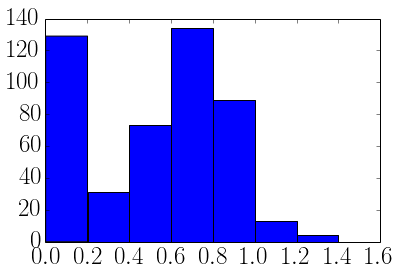

In [49]:
plt.hist(newdata2['RSN5_j']/newdata2['RSN5_r'],range=(.001,2))

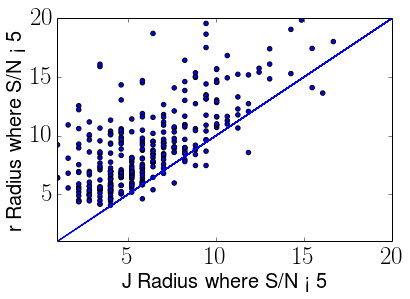

In [55]:
plt.scatter(newdata2['RSN5_j'],newdata2['RSN5_r'])
plt.plot(newdata2['RSN5_r'],newdata2['RSN5_r'])
plt.xlim(1,20)
plt.ylim(1,20)
plt.xlabel('J Radius where S/N < 5',fontsize=20)
plt.ylabel('r Radius where S/N < 5',fontsize=20)

In [111]:
10**(-10)

1e-10

# 